<a href="https://colab.research.google.com/github/danrongLi/MLEARN_course/blob/master/project/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Dependecies

I used google colab to run this file. The following code might cause some warnings, but the code will not be affected.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0

In [ ]:
!pip uninstall matplotlib
!pip install --upgrade matplotlib

# Import Libraries

In [2]:
from mxnet import gluon, init, np, npx, autograd
from mxnet.gluon import nn
from d2l import mxnet as d2l
import os
import pandas as pd

npx.set_np()

# Process Data

Download imdb dataset from d2l.

In [65]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

Write the function of convolution for 1 dimensional input with multiple input channels.

![Two-dimensional cross-correlation operation with a single input channel. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$.](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/conv1d-2d.svg?raw=1)
:label:`fig_conv1d_2d`

In [66]:
def corr1d(X, K):
    w = K.shape[0]
    Y = np.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = np.array([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = np.array([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

array([ 2.,  8., 14., 20., 26., 32.])

# TextCNN Model

For a single text sequence
with $n$ tokens represented by 
$d$-dimensional vectors,
the width, height, and number of channels
of the input tensor
are $n$, $1$, and $d$, respectively.
The textCNN model transforms the input
into the output as follows:

1. Define multiple one-dimensional convolution kernels and perform convolution operations separately on the inputs. Convolution kernels with different widths may capture local features among different numbers of adjacent tokens.
1. Perform max-over-time pooling on all the output channels, and then concatenate all the scalar pooling outputs as a vector.
1. Transform the concatenated vector into the output categories using the fully-connected layer. Dropout can be used for reducing overfitting.

![The model architecture of textCNN.](http://d2l.ai/_images/textcnn.svg)
:label:`fig_conv1d_textcnn`


In [67]:
class TextCNN(nn.Block):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.GlobalMaxPool1D()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.Sequential()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.add(nn.Conv1D(c, k, activation='relu'))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = np.concatenate((
            self.embedding(inputs), self.constant_embedding(inputs)), axis=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.transpose(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = np.concatenate([
            np.squeeze(self.pool(conv(embeddings)), axis=-1)
            for conv in self.convs], axis=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

Let us create a textCNN instance. It has 3 convolutional layers with kernel widths of 3, 4, and 5, all with 100 output channels.

In [68]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
net.initialize(init.Xavier(), ctx=devices)

# Load pre-trained GloVe word vectors

Load pretrained 100-dimensional GloVe embeddings
as the initialized token representations.
These token representations (embedding weights)
will be trained in `embedding`
and fixed in `constant_embedding`.

In [69]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.set_data(embeds)
net.constant_embedding.weight.set_data(embeds)
net.constant_embedding.collect_params().setattr('grad_req', 'null')

# Train & Evaluate Model

The following code to generate the graph would take >1h to run.

loss 0.090, train acc 0.969, test acc 0.864
32.3 examples/sec on [cpu(0)]


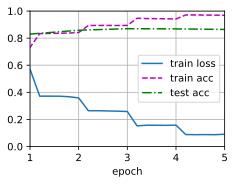

In [70]:
lr, num_epochs = 0.001, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [44]:
d2l.predict_sentiment(net, vocab, 'I cannot believe how amazing she is!')

'positive'

In [45]:
d2l.predict_sentiment(net, vocab, 'She is just a very terrible person')

'negative'

# Something Different - use sigmoid activation

In [52]:
class TextCNN2(nn.Block):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN2, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.GlobalMaxPool1D()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.Sequential()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.add(nn.Conv1D(c, k, activation='sigmoid'))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = np.concatenate((
            self.embedding(inputs), self.constant_embedding(inputs)), axis=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.transpose(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = np.concatenate([
            np.squeeze(self.pool(conv(embeddings)), axis=-1)
            for conv in self.convs], axis=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

The following code to generate the graph takes >1h to run.

loss 0.085, train acc 0.973, test acc 0.847
31.1 examples/sec on [cpu(0)]


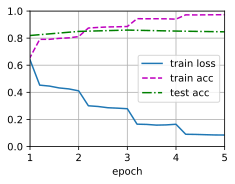

In [53]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net2 = TextCNN2(len(vocab), embed_size, kernel_sizes, nums_channels)
net2.initialize(init.Xavier(), ctx=devices)

net2.embedding.weight.set_data(embeds)
net2.constant_embedding.weight.set_data(embeds)
net2.constant_embedding.collect_params().setattr('grad_req', 'null')

lr, num_epochs = 0.001, 5
trainer = gluon.Trainer(net2.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net2, train_iter, test_iter, loss, trainer, num_epochs, devices)

# Something Different - use tfidf

Still use imdb dataset, but changed the data format to dataframe here.

In [3]:
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [14]:
def read_imdb(data_dir, is_train):
    # Read the IMDb review dataset text sequences and labels.
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
test_data = read_imdb(data_dir, is_train=False)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000
label: 1 review: Strangely, this version of OPEN YOUR EYES is more mature and
label: 1 review: Steve Biko was a black activist who tried to resist the whit
label: 1 review: I loved October Sky. The thing I loved most had to be the mu


In [13]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

train = pd.DataFrame(train_data).T
train.rename({0: 'sentence', 1: 'label'}, axis=1, inplace=True)
train.head()


,sentence,label
0,"Strangely, this version of OPEN YOUR EYES is m...",1
1,Steve Biko was a black activist who tried to r...,1
2,I loved October Sky. The thing I loved most ha...,1
3,Tintin and I recently aired as an episode of P...,1
4,"Once in the Life means that once a hoodlum, al...",1


In [15]:
test = pd.DataFrame(test_data).T
test.rename({0: 'sentence', 1: 'label'}, axis=1, inplace=True)
test.head()

,sentence,label
0,Anna Christie (1930)<br /><br />Anna Christie ...,1
1,"In Spain, the former sailor Ramón Sampedro (Ja...",1
2,The Closer She Gets... is an artful documentar...,1
3,I consider myself lucky that I got to view a w...,1
4,Evil warlord puts a town through pain and suff...,1
